## Pesos de Evidencia - Weight of evidence WoE

Pesos de Evidencia - Weight of Evidence (WoE) por sus siglas en inglés fue desarrollado principalmente por las industrias de crédito y financieras para construir mejores modelos para la predicción de riesgo de incumplimiento de pago en préstamos. Es decir, predecir que tan probable es que el dinero prestado a una persona o institución no sea devuelto. El Peso de Evidencia, es una medida de la "fortaleza" de una técnica de agroupamiento para separar riesgo alto y bajo (riesgo de incumpliemiento).

WoE es calculado a partir de la probabilidad básica: ln( (Proporción de Buen Resultado Crediticio) / (Proporción de Mal Resultado Crediticio))

- WoE será 0 si la P(Buen Resultado) / P(Mal Resultado) = 1, es decir, si el resultado es aleatorio para ese grupo.
- Si P(Mal Resultado) > P(Buen Resultado) el índice de probabilidad será < 1 y,
- WoE no será < 0 si,  P(Buen Resultado) > P(Mal Resultado).

WoE es adecuado para Regresiones Logísticas porque la transformación Logit es simplemente el logaritmo (log) de la probabilidad, es decir, ln(P(Buen Resultado)/P(Mal Resultado)). Por lo tanto, usando variables codificadas con WoE en los regresores logísticos, genera variables codificadas en la misma escala, y los parámetros de la ecuación en la regresión lineal pueden ser comparados directamente.

La transformación WoE tiene tres ventajas:

- Crea una relación monotónica entre el target y las variables independientes.
- Ordena las categorías en una escala 'logística' lo cual es natural para una regresión logísitica.
- Las variables transformadas pueden ser comparadas porque estan en la misma escala. Por lo tanto, es posible determinar cuales son más predictivas.

WoE tiene also una limitación:

- Tiende a causar sobre-ajustes
- No está definida cuando el denomiador es 0

Más detalles en el siguiente link [link](http://documentation.statsoft.com/StatisticaHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview)


## En este demo:

Vamos a aprender como transformar WoE con:
- pandas
- Feature-Engine

y vamos a ver las ventajas y limitaciones de cada una de estas implementaciones usando los datos del Titanic.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# separar los datos 
from sklearn.model_selection import train_test_split

# para codificar usando feature-engine
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder

In [2]:
# cargar los datos

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# removamos las observaciones con datos ausentes na en embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [4]:
# Ahora extraemos la primera letra de la variable cabin
# para facilitar el demo
data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# remover las observaciones donde cabin = T
# ya que solo son unas pocas

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [6]:
# miremos cuantas categorías tiene cada variable

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' etiquetas')

survived :  2  etiquetas
sex :  2  etiquetas
cabin :  8  etiquetas
embarked :  3  etiquetas


In [7]:
# exploremos las categorías únicas
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Importante

Calculamos los WoE usando el segmento de entrenamiento, y luego usamos ese mapeo en el segmento de prueba.

Para implementarlo en pandas, tenemos que mantener el target en el segmento de entrenamiento.


In [10]:
# separemos en segmentos de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # percentaje de observaciones en el segmento de prueba
    random_state=0)  # seed asegurar reproducibilidad

X_train.shape, X_test.shape


((914, 4), (392, 4))

### Exploremos la relación original entre las variables categóricas y el target

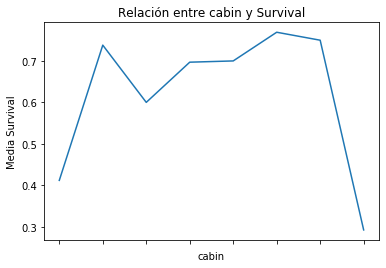

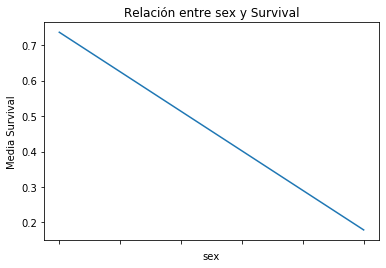

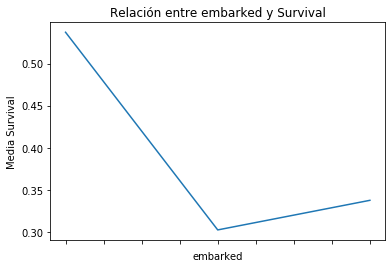

In [11]:
# Exploremos la relación original entre las variables categóricas y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación entre {} y Survival'.format(var))
    fig.set_ylabel('Media Survival')
    plt.show()

Podemos ver que la relación entre el target y cabin, embarked sube y baja dependiendo de la categoría. 


## Pesos de Evidencia - Weight of Evidence con pandas

### Ventajas

- rápido
- retorna un pandas dataframe

### Limitaciones de pandas:

- no preserva la información del segmento de entrenamiento para propagarlo al segmento de prueba

Necesitamos capturar y guardar los mapeos uno por uno, manualmente, si estamos planeando usarlos en producción


In [12]:
# calculemos la probabilidad de survived = 1 por categoría

prob_df = X_train.groupby(['cabin'])['survived'].mean()

# y lo guardamos en un dataframe
prob_df = pd.DataFrame(prob_df)
prob_df

,survived
cabin,
A,0.411765
B,0.738095
C,0.600000
D,0.696970
E,0.700000
F,0.769231
G,0.750000
n,0.292199


In [13]:
# y ahora la probabilidad de survived = 0

prob_df['died'] = 1-prob_df['survived']

prob_df

,survived,died
cabin,,
A,0.411765,0.588235
B,0.738095,0.261905
C,0.600000,0.400000
D,0.696970,0.303030
E,0.700000,0.300000
F,0.769231,0.230769
G,0.750000,0.250000
n,0.292199,0.707801


In [14]:
#  y ahora WoE

prob_df['ratio'] = np.log( prob_df['survived'] / prob_df['died'] )

prob_df

,survived,died,ratio
cabin,,,
A,0.411765,0.588235,-0.356675
B,0.738095,0.261905,1.036092
C,0.600000,0.400000,0.405465
D,0.696970,0.303030,0.832909
E,0.700000,0.300000,0.847298
F,0.769231,0.230769,1.203973
G,0.750000,0.250000,1.098612
n,0.292199,0.707801,-0.884730


In [15]:
# y ahora capturemos el woe en un diccionario 

ordered_labels = prob_df['ratio'].to_dict()

ordered_labels

{'A': -0.35667494393873245,
 'B': 1.0360919316867758,
 'C': 0.4054651081081642,
 'D': 0.8329091229351043,
 'E': 0.8472978603872034,
 'F': 1.2039728043259361,
 'G': 1.0986122886681098,
 'n': -0.8847299269619376}

In [16]:
# ahora, reemplazamos las etiquetas con el WoE

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [17]:
# exporemos el resultado

X_train['cabin'].head(10)

843    -0.884730
869    -0.884730
430    -0.884730
481    -0.884730
1308   -0.884730
456    -0.884730
118     0.832909
485     0.832909
297    -0.884730
263     0.847298
Name: cabin, dtype: float64

In [18]:
# agrupemos los comandos anteriores en dos funciones

def find_category_mappings(df, variable, target):

    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    
    tmp['non-target'] = 1 - tmp[target]
    
    tmp['ratio'] = np.log( tmp[target] / tmp['non-target'] )

    return tmp['ratio'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [19]:
# ahora repitamos con un ciclo para cada una de las variables categoricas

for variable in ['sex', 'embarked']:
    
    mappings = find_category_mappings(X_train, variable, 'survived')
    
    integer_encode(X_train, X_test, variable, mappings)

In [20]:
# veamos el resultado

X_train.head()

,cabin,sex,embarked,survived
843,-0.88473,-1.522770,-0.674455,0
869,-0.88473,-1.522770,-0.674455,0
430,-0.88473,1.025409,-0.674455,1
481,-0.88473,1.025409,0.149212,1
1308,-0.88473,-1.522770,-0.674455,0


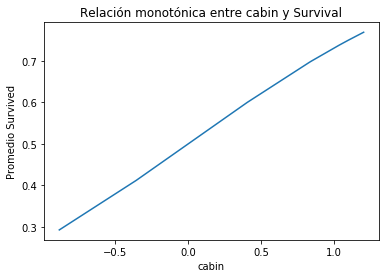

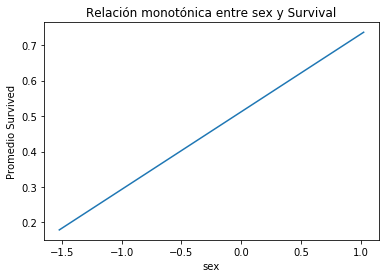

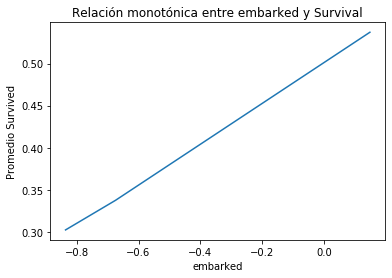

In [21]:
# inspeccionemos la relación monotónica
# entre la variable y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación monotónica entre {} y Survival'.format(var))
    fig.set_ylabel('Promedio Survived')
    plt.show()

Podemos ver de las gráficas que la relación entre las categorias y el target ahora es monotónica.

### Nota
Reemplazar las etiquetas con código anterior siguiendo este método va a generar valores faltantes para las categorias presentes en el segmento de prueba que no se encuentra en el de entrenamiento. Por lo tanto es extremadamente importante, manejar las etiquetas poco comunes con prelación. Explicaremos como hacer esto más adelante en otro notebook.


**Importante: generaremos NA o Inf si la probabilidad si el target = 0 es cero, ya que la división por cero no esta definida. **


## Pesos de Evidencia - Weight of Evidence con feature-engine

Si usamos Feature-Engine, en lugar de pandas, no necesitamos mantener el target en el segmento de entrenamiento.

In [22]:
# separemos en segmentos de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # predictores
    data['survived'],  # target
    test_size=0.3,  # porcentaje de observaciones en el segmento de prueba
    random_state=0)  # seed asegurar reproducibilidad
X_train.shape, X_test.shape

((914, 3), (392, 3))

In [23]:
woe_enc = WoERatioCategoricalEncoder(
    encoding_method = 'woe',
    variables=['cabin', 'sex', 'embarked'])

In [24]:
# cuando ajustamos el transformador, necesitamos pasar 
# el target, al igual que las otras clases de predictores de Scikit-learn 
woe_enc.fit(X_train, y_train)

WoERatioCategoricalEncoder(encoding_method='woe',
                           variables=['cabin', 'sex', 'embarked'])

In [25]:
# en el dict del encoder podemos el WoE
# asignado a cada una de las categorias por cada variable

woe_enc.encoder_dict_

{'cabin': {'A': -0.35667494393873245,
  'B': 1.0360919316867758,
  'C': 0.4054651081081642,
  'D': 0.8329091229351043,
  'E': 0.8472978603872034,
  'F': 1.2039728043259361,
  'G': 1.0986122886681098,
  'n': -0.8847299269619376},
 'sex': {'female': 1.0254088846448146, 'male': -1.5227695297884265},
 'embarked': {'C': 0.14921239818667575,
  'Q': -0.8362480242006187,
  'S': -0.6744550475477927}}

In [26]:
# esta es la lista de variables que el codificador transforma
woe_enc.variables

['cabin', 'sex', 'embarked']

In [27]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# exploremos el resultado
X_train.head()

,cabin,sex,embarked
843,-0.88473,-1.522770,-0.674455
869,-0.88473,-1.522770,-0.674455
430,-0.88473,1.025409,-0.674455
481,-0.88473,1.025409,0.149212
1308,-0.88473,-1.522770,-0.674455


**Nota**

Si el argumento 'variables' se fija en 'None' (ninguno), entonces el codificador automaticamente indentificará  **todas las variables categóricas**. Maravilloso verdad?

El codificador no codificará las variables numéricas. Por lo tanto, si algunas de tus variables categoricas son de hecho numericas, necesita hacer el 're-cast' o cambio como 'object' antes de usar el codificador.

Si hay una variable en el segmento de prueba, para el cual el codificador no tiene un número para asignar ( la categoria no estaba presente en el segmento de entrenamiento), el codificador devolvera un error, para alertarte del problema

Finalmente, si la probabilidad del target = 0 es cero para cualquier categoria, el codificador devolvera un error ya que la división por cero no esta definida.